In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split


# Reading Files

In [53]:
df = pd.read_csv('../../data/processedData/training_data.csv')
df = df.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)

# Model Fitting

### Step 1: data preparation

In [64]:
# Split the dataset into training and testing sets
X = df.drop('Cardiovascular', axis=1)  # Features (drop the target variable 'Cardiovascular')
y = df['Cardiovascular']  # Target variable

# Split data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Step 2: Pipeline with Feature Selection and Hyperparameter Tuning for SVM Using GridSearchCV

In [65]:
# Use LinearSVC for RFE
svm = LinearSVC(max_iter=5000)

# Define a pipeline with standardization and RFE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('feature_selection', RFE(estimator=svm)),  # RFE for feature selection
    ('svm', svm)  # LinearSVC model
])

# Define the hyperparameter search space, including n_features_to_select
param_grid = {
    'feature_selection__n_features_to_select':list(range(1, X_train.shape[1] + 1)),  # Try different numbers of features
    'svm__C': [0.1, 1, 10, 100]  # Regularization parameter for LinearSVC
}

# Perform a grid search with 20-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Perform hyperparameter search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'feature_selection__n_features_to_select': 21, 'svm__C': 1}


### Step 3: Evaluate model performance on a test set

In [66]:
# Use the best model with optimal parameters to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8734
Precision: 0.8152
Recall: 0.6303
F1 Score: 0.7109


### Step 4: Plot the ROC curve

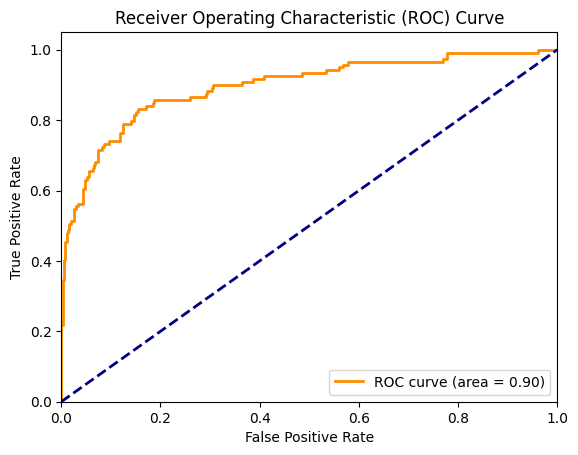

In [67]:
# Get the predicted probability scores (decision function) from the model
y_score = grid_search.best_estimator_.decision_function(X_test)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The current SVM model demonstrates an accuracy of 87.34%, indicating that the model is relatively solid in correctly classifying patients. The precision of 81.52% suggests that the model effectively reduces false positives, which is valuable in minimizing the number of patients mistakenly identified as at risk. However, the relatively low recall of 63.03% means that the model is missing a significant portion of actual positive cases (patients truly at risk for cardiovascular complications). Therefore, further optimization of the model is needed.

#### Handling Imbalanced Data with Balanced Class Weights in SVM

In [58]:
print(y.value_counts())

Cardiovascular
0.0    1206
1.0     398
Name: count, dtype: int64


From the output it can be seen that the y data is unbalanced. There are 1206 samples with a category of 0.0, while there are only 398 samples with a category of 1.0. Typically, when there is a large difference in the number of samples between categories, the model may be biased towards predicting the category with the larger number during training.

In [70]:
# Use LinearSVC for RFE with class_weight='balanced'
svm = LinearSVC(max_iter=5000, class_weight='balanced')

# Define a pipeline with standardization and RFE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('feature_selection', RFE(estimator=svm)),  # RFE for feature selection
    ('svm', svm)  # LinearSVC model with class_weight='balanced'
])

# Define the hyperparameter search space, including n_features_to_select
param_grid = {
    'feature_selection__n_features_to_select':list(range(1, X_train.shape[1] + 1)),  # Try different numbers of features
    'svm__C': [0.1, 1, 10, 100]  # Regularization parameter for LinearSVC
}

# Perform a grid search with 20-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Perform hyperparameter search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

# Use the best model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)


Best Parameters:  {'feature_selection__n_features_to_select': 21, 'svm__C': 1}


In [71]:
# Extract the RFE selector and the final SVM model from the best pipeline
best_pipeline = grid_search.best_estimator_
rfe_selector = best_pipeline.named_steps['feature_selection']  # Get the RFE selector
svm_model = best_pipeline.named_steps['svm']  # Get the trained SVM model

# Get the selected features mask and the ranking of features
selected_features = rfe_selector.support_  # Boolean mask for selected features

# Get the coefficients (weights) from the trained LinearSVC model
coefficients = svm_model.coef_[0]  # Coefficients for the selected features

# Get the feature names (assuming X_train is a DataFrame with column names)
feature_names = X_train.columns[selected_features]

# Print the selected features and their corresponding coefficients
print("Selected features and their coefficients (sorted by coefficient magnitude):")
for feature, coef in sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True):
    print(f"Feature: {feature}, Coefficient: {coef:.4f}")

Selected features and their coefficients (sorted by coefficient magnitude):
Feature: vt_freq_power, Coefficient: -0.4032
Feature: qrs_freq_power, Coefficient: 0.3979
Feature: Erythrocytes, Coefficient: 0.3014
Feature: Erythrocyte distribution width, Coefficient: 0.2582
Feature: Hematocrit, Coefficient: -0.1984
Feature: Erythrocyte mean corpuscular hemoglobin, Coefficient: -0.1671
Feature: Erythrocyte mean corpuscular hemoglobin concentration, Coefficient: 0.1464
Feature: Hemoglobin, Coefficient: 0.1450
Feature: ASA_RATING_C, Coefficient: 0.1424
Feature: LOS, Coefficient: 0.1112
Feature: cardiac_history, Coefficient: 0.0864
Feature: PATIENT_CLASS_NM, Coefficient: 0.0771
Feature: arc_peak_frequency, Coefficient: -0.0755
Feature: ICU_ADMIN_FLAG, Coefficient: 0.0693
Feature: vf_freq_power, Coefficient: -0.0664
Feature: diastolic_peak, Coefficient: 0.0622
Feature: PATIENT_CLASS_GROUP, Coefficient: 0.0617
Feature: ORDER_STATUS_IMPACT, Coefficient: -0.0562
Feature: arc_bandwidth, Coefficient:

Accuracy: 0.8402
Precision: 0.6346
Recall: 0.8319
F1 Score: 0.7200


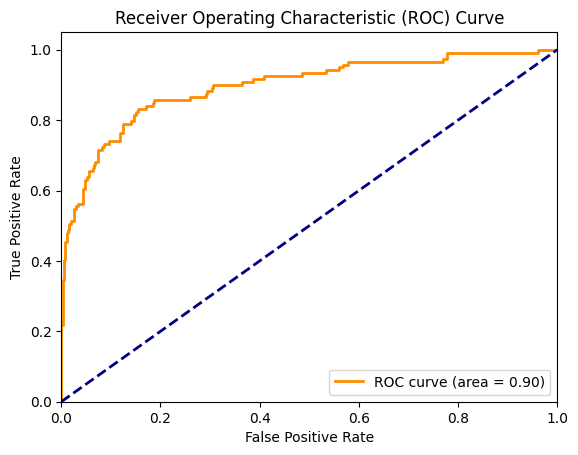

In [72]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The model using `class_weight='balanced'` shows an accuracy of 84.02%, which indicates a slight drop in overall correct classifications compared to the previous SVM model. However, the recall has significantly improved to 83.19%, suggesting that the model is much better at identifying actual positive cases (patients at risk for cardiovascular complications). On the other hand, the precision has decreased to 63.46%, meaning that there are more false positives, but this trade-off is acceptable given the improved ability to detect high-risk patients. The F1 score of 0.7200 reflects a balanced performance between precision and recall. Overall, this model better addresses the primary goal of reducing missed cases in cardiovascular risk prediction.

#### Handling Imbalanced Data Using SMOTE in SVM

Best Parameters:  {'feature_selection__n_features_to_select': 20, 'svm__C': 0.1}
Accuracy: 0.8216
Precision: 0.6170
Recall: 0.7311
F1 Score: 0.6692


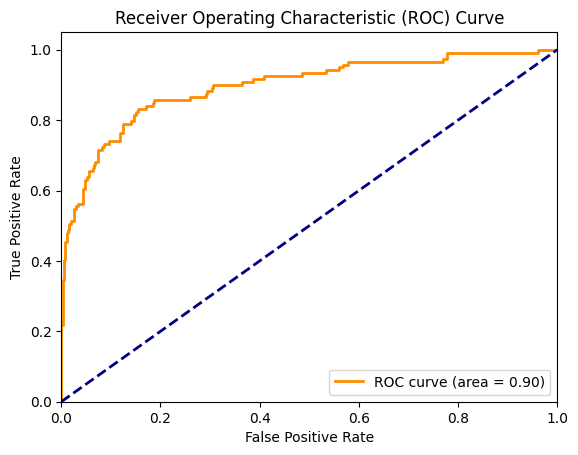

In [74]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)

# Oversample the training data using SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Use LinearSVC for RFE (no class_weight='balanced')
svm = LinearSVC(max_iter=5000)

# Define a pipeline with standardization and RFE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('feature_selection', RFE(estimator=svm)),  # RFE for feature selection
    ('svm', svm)  # LinearSVC model
])

# Define the hyperparameter search space, including n_features_to_select
param_grid = {
    'feature_selection__n_features_to_select':list(range(1, X_train.shape[1] + 1)),  # Try different numbers of features
    'svm__C': [0.1, 1, 10, 100]  # Regularization parameter for LinearSVC
}

# Perform a grid search with 20-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Perform hyperparameter search on the SMOTE-processed training set
grid_search.fit(X_train_smote, y_train_smote)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

# Use the best model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Compared to the model using `class_weight='balanced'`, the model with SMOTE achieves a recall of 73.11%, while the `class_weight='balanced'` model reaches a higher recall of 83.19%. However, the SMOTE model shows a lower precision at 61.70%, whereas the `class_weight='balanced'` model achieves a slightly better precision of 63.46%.

Given that recall is crucial in minimizing false negatives (i.e., patients with cardiovascular risks who are not identified), the `class_weight='balanced'` model demonstrates superior performance in this context. While the difference in precision is small, the focus on recall in predicting postoperative cardiovascular risk makes the `class_weight='balanced'` model more appropriate for our purposes. Therefore, the model with `class_weight='balanced'` is selected as the final model.

### Comparison Model: SVM Model with Feature Selection Using f_classif

Best Parameters:  {'feature_selection__k': 10, 'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Accuracy: 0.8548
Precision: 0.7025
Recall: 0.7143
F1 Score: 0.7083


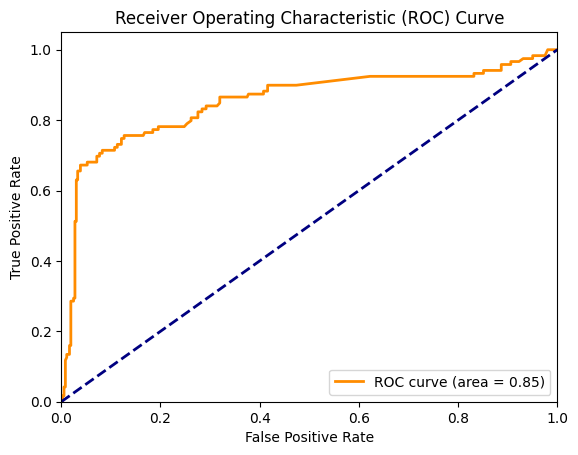

In [76]:
# Define a pipeline that includes standardization, feature selection, and SVM model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('feature_selection', SelectKBest(f_classif)),  # Feature selection
    ('svm', SVC(probability=True, class_weight='balanced'))  # SVM model, handles class imbalance
])

# Define the hyperparameter search space
param_grid = {
    'feature_selection__k': list(range(1, X_train.shape[1] + 1)),  # Number of features to select in the feature selection step
    'svm__C': [0.1, 1, 10, 100],  # C parameter for SVM
    'svm__gamma': [1, 0.1, 0.01, 0.001],  # Gamma parameter for SVM
    'svm__kernel': ['rbf']  # SVM kernel function
}

# Perform hyperparameter tuning using 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Train on the training set while searching for the best parameters
grid_search.fit(X_train, y_train)

# Output the best parameter combination found
print("Best Parameters: ", grid_search.best_params_)

# Use the best model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Predict probabilities for the test set
y_score = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()